# Comments
- Displaying the training dynamics for extractive and multiple-choice QA.

# Import

In [2]:
import os
import re
import numpy as np
import copy
import random
import spacy
import json
import torch
import pandas as pd
import torch.nn.functional as F
from tqdm import tqdm
from collections import Counter
import pickle
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from pathlib import Path
import statistics
import spacy
from utils import load_json, save_json, Statistics
from evaluate import evaluate

In [3]:
plt.rcParams['font.family'] = 'Times New Roman'

In [4]:
import matplotlib as mpl
# mpl.rcParams['mathtext.fontset'] = 'stix'
# mpl.rcParams['mathtext.rm'] = 'stix'

In [5]:
def get_offset_id2w(doc):
    # from char index to word index
    id2w = {}
    tm1 = 0
    for i, t in enumerate(doc):
        for j in range(tm1, t.idx):
            id2w[j] = i - 1
        tm1 = t.idx
    for j in range(t.idx, t.idx+len(t)+1):
        id2w[j] = i
    return id2w

In [6]:
import seaborn as sns
# sns.set()
sns.set_theme(style="whitegrid")

In [22]:
task_type = 'ex-qa'
# task_type = 'mc-qa'

output_dir = Path('output/')
dataset_dir = Path('dataset/')

In [9]:
def get_analysis_result(key, name, task_type):
    analysis_dir = output_dir / f'analysis/{task_type}/'
    analysis_file = analysis_dir / f"{key}_{name}.json"
    analysis_result = load_json(analysis_file)
    return analysis_result

## func: get_category

In [13]:
def get_category(aps, qcss, ac, dim):
    category = ''

    ### answer-position-sentence ###
    if dim == 3:
        if aps is not None:
            if aps == 0:
                category += 'I'
            else:
                category += 'O'
        else:
            category += 'O'

    ### question-context-similar-sent ###
    if dim == 2 or dim == 3:
        if qcss is not None:
            if qcss == aps:
                category += 'I'
            else:
                category += 'O'
        else:
            # None
            category += 'O'

    ### answer-candidates ###
    if dim == 2 or dim == 3:
        if ac is not None:
            if ac == 1:
                category += 'I'
            else:
                category += 'O'
        else:
            # exclude
            category += '-'
    return category

In [18]:
def score_dict_to_stats(score_dict, dim=3):
    results = defaultdict(Statistics)
    
    for _id, score in score_dict.items():
        aps = ar['answer-position-sentence'][_id]
        qcss = ar['question-context-similar-sent'][_id]
        ac = ar['answer-candidates'][_id]
        
        category = get_category(aps, qcss, ac, dim)
        results[category].update_dict(score)

    return results

In [19]:
def score_dict_to_stats_ac(score_dict, threshold=None):
    results_ac = defaultdict(Statistics)
    for _id, score in score_dict.items():
        aps = ar['answer-position-sentence'][_id]
        qcss = ar['question-context-similar-sent'][_id]
        ac = ar['answer-candidates'][_id]
        if ac is not None:
            if threshold is None:
                results_ac[str(ac)].update_dict(score)
            else:
                if 1 <= ac <= threshold:
                    results_ac[str(ac)].update_dict(score)
                elif ac >= threshold + 1:
                    results_ac[f'{threshold+1}~'].update_dict(score)
    return results_ac

# EXQA

In [23]:
train_file = dataset_dir / 'ex-qa/squad/train-v1.1.json'

In [24]:
train_file = dataset_dir / 'ex-qa/mrqa/train/NaturalQuestionsShort-train-from-MRQA.json'

In [25]:
train_file_name = train_file.stem

## Models

In [42]:
models = [
    'bert_squad_biased-aps-0-qcss-0-ac-1_10ep_3k-ex_seed42', # III
    # 'roberta_squad_biased-aps-0-qcss-0-ac-1_10ep_3k-ex',
    # 'bert_squad_biased-aps-0_5ep',
    # 'bert_squad_biased-aps-0-qcss-notequal-aps-ac-geq-2_10ep', # IOO
    # 'bert_squad_biased-aps-geq-1-qcss-same-aps-ac-geq-2_5ep', # OIO
    # 'bert_squad_biased-aps-geq-1-qcss-same-aps-ac-geq-2_10ep_2k-ex', #OIO 2k
    # 'bert_squad_biased-aps-geq-1-qcss-notequal-aps-ac-1_10ep', # OOI
    
    # 'bert_squad_blend-aps-0.01_seed42',
    # 'bert_squad_blend-aps-0.1_seed42',
    # 'bert_squad_blend-aps-0.5_seed42',

    # 'bert_squad_blend-ac-0.01_seed42',
    # 'bert_squad_blend-ac-0.1_seed42',
    # 'bert_squad_blend-ac-0.5_seed42',
    
    # 'bert_squad_blend-qcss-0.01_seed42',
    # 'bert_squad_blend-qcss-0.1_seed42',
    
    # 'bert_squad_biased-aps-0_5ep',
    # 'bert_squad_biased-qcss-same-aps_5ep',
    # 'bert_squad_biased-ac-1_5ep',
    
    'bert_squad_1d-blend-aps-0.0_seed42',
    'bert_squad_1d-blend-aps-0.01_seed42',
    'bert_squad_1d-blend-aps-0.05_seed42',
    'bert_squad_1d-blend-aps-0.1_seed42',
    'bert_squad_1d-blend-aps-0.2_seed42',
    'bert_squad_1d-blend-aps-0.5_seed42',

    'bert_squad_1d-blend-qcss-0.0_seed42',
    'bert_squad_1d-blend-qcss-0.01_seed42',
    'bert_squad_1d-blend-qcss-0.05_seed42',
    'bert_squad_1d-blend-qcss-0.1_seed42',
    'bert_squad_1d-blend-qcss-0.2_seed42',
    'bert_squad_1d-blend-qcss-0.5_seed42',

    'bert_squad_1d-blend-ac-0.0_seed42',
    'bert_squad_1d-blend-ac-0.01_seed42',
    'bert_squad_1d-blend-ac-0.05_seed42',
    'bert_squad_1d-blend-ac-0.1_seed42',
    'bert_squad_1d-blend-ac-0.2_seed42',
    'bert_squad_1d-blend-ac-0.5_seed42',
]

In [332]:
models = [
    "bert_squad_3d-biased-aps-qcss-ac_seed42",
    "bert_squad_2d-biased-qcss-ac_seed42",
]

In [115]:
models = [
    'bert_nq_biased-aps-0-qcss-0-ac-1_10ep_4k-ex'
]

In [304]:
models = [
    "bert_nq_biased-aps-1-qcss-0-ac-0_5k-ex",
    "bert_nq_biased-aps-0-qcss-1-ac-0_5k-ex",
    "bert_nq_biased-aps-0-qcss-0-ac-1_5k-ex",
]

In [260]:
models = [
    "bert_squad_biased-aps_5k-ex_seed42",
    "bert_squad_biased-qcss_5k-ex_seed42",
    "bert_squad_biased-ac_5k-ex_seed42",
]

In [223]:
models = [
    'bert_squad_5k-ex_seed42',
    'bert_squad_5k-ex_seed43',
    'bert_squad_5k-ex_seed44',
    'bert_squad_5k-ex_seed45',
    'bert_squad_5k-ex_seed46',
]

In [523]:
models = [
    'bert_squad_vis-aps_1400-ex_seed42',
    'bert_squad_vis-qcss_1400-ex_seed42',
    'bert_squad_vis-ac_1400-ex_seed42',
]

In [530]:
models = [
    'bert_nq_vis-aps_4k-ex_seed42',
    'bert_nq_vis-qcss_4k-ex_seed42',
    'bert_nq_vis-ac_4k-ex_seed42',
]

In [204]:
models = [
    'bert_squad',
]

In [211]:
models = [
    'bert_nq',
]

In [ ]:
# model = 'bert_squad_biased-aps-0-qcss-0-ac-1_10ep_3k-ex'
# model = 'roberta_squad_biased-aps-0-qcss-0-ac-1_10ep_3k-ex'

## Test Set

In [525]:
test_file = '/works/data0/shinoda/dataset/ex-qa/squad/dev-v1.1.json'
# test_file = '/works/data0/shinoda/dataset/ex-qa/mrqa/dev/NaturalQuestionsShort-dev-from-MRQA.json'
test_file_name = Path(test_file).stem
test_set = load_json(test_file)

In [214]:
test_file = '/works/data0/shinoda/dataset/ex-qa/mrqa/dev/NaturalQuestionsShort-dev-from-MRQA.json'
test_file_name = Path(test_file).stem
test_set = load_json(test_file)
# model = 'bert_nq_biased-aps-0-qcss-0-ac-1_10ep_4k-ex'

In [17]:
for m in models:
    predictions = load_json(output_dir / 'ex-qa' / m / f'predictions_{test_file_name}_.json')
    all_score, score_dict = evaluate(test_set['data'], predictions, return_dict=True)

## Count examples

In [481]:
APS = 'answer-position-sentence'
QCSS = 'question-context-similar-sent'
AC = 'answer-candidates'

In [533]:
# data_name = 'train-v1.1'
data_name = 'NaturalQuestionsShort-train-from-MRQA'

keys = [
    APS, QCSS, AC
]
ar_train = {}
for k in keys:
    ar_train[k] = get_analysis_result(k, data_name, 'ex-qa')

(array([11194., 10729.,  8762.,  6222.,  4492.,  2948.,  1956.,  1320.,
          877.,   617.,   609.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <BarContainer object of 11 artists>)

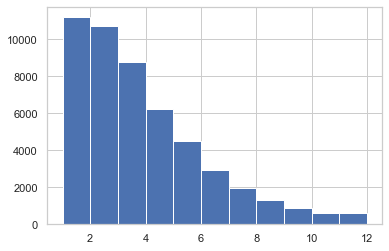

In [164]:
plt.hist([i for i in ar_train[AC].values() if i is not None], bins=[1,2,3,4,5,6,7,8,9,10,11,12])

In [115]:
n = 0
m = 0
for i in ar[APS]:
    if ar[APS][i] != ar[QCSS][i] and ar[QCSS][i] is not None:
        n += 1
    if ar[APS][i] != ar[QCSS][i]:
        m += 1

In [116]:
n, m, len(ar[APS])

(16307, 23148, 87599)

In [461]:
cached_features_file = "/works/data0/shinoda/dataset/ex-qa/squad/cached_train-v1.1_bert-base-uncased_384"
train_features = torch.load(cached_features_file)["features"]

In [534]:
cached_features_file = "/works/data0/shinoda/dataset/ex-qa/mrqa/train/cached_NaturalQuestionsShort-train-from-MRQA_bert-base-uncased_384"
train_features = torch.load(cached_features_file)["features"]

In [535]:
short_context_ids = [_id for _id, num in Counter([feat.qas_id for feat in train_features]).items() if num == 1]

In [465]:
len(short_context_ids), len(train_features)

(86706, 88641)

In [536]:
len(short_context_ids), len(train_features)

(90170, 180741)

In [537]:
cat3d = []
cat2d = []
cat_aps = []
cat_qcss = []
cat_ac = []

do_exclude_long_context = True

if do_exclude_long_context:
    ids = short_context_ids
else:
    ids = ar_train[APS].keys()

for _id in ids:
    aps = ar_train[APS][_id]
    qcss = ar_train[QCSS][_id]
    ac = ar_train[AC][_id]
    
    if ac is None:
        continue
        
    if qcss is None:
        continue

    cat3d.append(f"{int(aps == 0)}"f"{int(qcss == aps)}"f"{int(ac == 1)}")
    cat2d.append(f"{int(qcss == aps)}"f"{int(ac == 1)}")

## Evaluation

In [531]:
test_file_name

'dev-v1.1'

In [527]:
keys = [
    'answer-position-sentence',
    'question-context-similar-sent',
    'answer-candidates',
]
ar = {}
for k in keys:
    ar[k] = get_analysis_result(k, test_file_name, 'ex-qa')

In [532]:
if 'squad' in models[0]:
    test_file = '/works/data0/shinoda/dataset/ex-qa/squad/dev-v1.1.json'
elif 'nq' in models[0]:
    test_file = '/works/data0/shinoda/dataset/ex-qa/mrqa/dev/NaturalQuestionsShort-dev-from-MRQA.json'
else:
    raise ValueError("")
test_file_name = Path(test_file).stem
test_set = load_json(test_file)

keys = [
    'answer-position-sentence',
    'question-context-similar-sent',
    'answer-candidates',
]
ar = {}
for k in keys:
    ar[k] = get_analysis_result(k, test_file_name, 'ex-qa')

for m in models:
    predictions = load_json(output_dir / 'ex-qa' / m / f'predictions_{test_file_name}_.json')
    all_score, score_dict = evaluate(test_set['data'], predictions, return_dict=True)

    results = defaultdict(Statistics)
    
    for _id, score in score_dict.items():
        aps = ar['answer-position-sentence'][_id]
        qcss = ar['question-context-similar-sent'][_id]
        ac = ar['answer-candidates'][_id]
        if qcss is None:
            continue
        if ac is None:
            continue
        if '1d-blend-aps' in m or 'squad_biased-aps_5k-ex_seed42' in m:
            category = str(int(aps == 0))
        elif '1d-blend-qcss' in m or 'squad_biased-qcss_5k-ex_seed42' in m:
            category = str(int(qcss == aps))
        elif '1d-blend-ac' in m or 'squad_biased-ac_5k-ex_seed42' in m:
            category = str(int(ac == 1))
        else:
            category = get_category(aps, qcss, ac, 3)
        results[category].update_dict(score)
        
    print('Model:', m)
    print('Test Set:', test_file_name)
    if '1d' in m:
        cats = ['1', '0']
    else:
        cats = ['III', 'IIO', 'IOI', 'OII', 'IOO', 'OIO', 'OOI', 'OOO']
    for c in cats:
        stat = results[c]
        result = stat.mean()
        f1 = result['F1']
        em = result['EM']
        print(c, '\t', round(f1 * 100, 2)) # , '\t', stat.global_update)
    print()
    
    """
    print('answer-candidates')
    cats = sorted(results_ac.keys())
    for c in cats:
        stat = results_ac[c]
        print(c, '\t', stat.mean(), '\t', stat.global_update)
        if c >= 13:
            break
    print()
    """

Model: bert_nq_vis-aps_4k-ex_seed42
Test Set: NaturalQuestionsShort-dev-from-MRQA
III 	 76.77
IIO 	 73.37
IOI 	 84.84
OII 	 59.11
IOO 	 83.93
OIO 	 38.16
OOI 	 25.59
OOO 	 17.91

Model: bert_nq_vis-qcss_4k-ex_seed42
Test Set: NaturalQuestionsShort-dev-from-MRQA
III 	 70.79
IIO 	 67.75
IOI 	 51.83
OII 	 76.23
IOO 	 30.49
OIO 	 74.67
OOI 	 59.05
OOO 	 50.64

Model: bert_nq_vis-ac_4k-ex_seed42
Test Set: NaturalQuestionsShort-dev-from-MRQA
III 	 67.73
IIO 	 47.51
IOI 	 63.09
OII 	 79.36
IOO 	 33.28
OIO 	 49.87
OOI 	 74.21
OOO 	 48.64



In [39]:
results

defaultdict(my_utils.data.stat.Statistics,
            {'0': <my_utils.data.stat.Statistics at 0x7fbfaefd04a8>,
             '1': <my_utils.data.stat.Statistics at 0x7fbfaefd0438>,
             'III': <my_utils.data.stat.Statistics at 0x7fbfaefd0198>})

In [74]:
predictions = load_json(output_dir / 'ex-qa' / model / f'predictions_{test_file_name}_.json')
all_score, score_dict = evaluate(test_set['data'], predictions, return_dict=True)

In [118]:
predctions_list = list((output_dir / 'ex-qa' / model).glob(f'predictions_{test_file_name}_*.json'))

In [76]:
# SQuAD
steps = ['100', '200', '300', '400', '500', '600', '700', '800', '900', '1000', '1100', '']
# NQ
# steps = ['100', '200', '300', '400', '500', '600', '700', '800', '900', '1000', '1100', '1200', '1300', '']
cats = ['III', 'IIO', 'IOI', 'OII', 'IOO', 'OIO', 'OOI', 'OOO']

In [78]:
seeds = [42, 43, 44, 45, 46]
models = []
for seed in seeds:
    models.append(f'bert_squad_biased-aps-0-qcss-0-ac-1_10ep_3k-ex_seed{seed}')
    # models.append(f'bert_nq_biased-aps-0-qcss-0-ac-1_10ep_4k-ex_seed{seed}')

## Training Dynamics

In [504]:
# exp_type = 'bert_squad'
# exp_type = 'roberta_squad'
# exp_type = 'bert_nq'
exp_type = 'roberta_nq'


# exp_type = 'bert_squad_2d'

# exp_type = 'bert_nq_2d'

In [505]:
if '2d' in exp_type:
    cats = ['II', 'IO', 'OI', 'OO']
else:
    cats = ['III', 'IIO', 'IOI', 'OII', 'IOO', 'OIO', 'OOI', 'OOO']
seeds = [42, 43, 44, 45, 46]
models = []
for seed in seeds:
    if exp_type == 'bert_squad':
        # models.append(f'bert_squad_biased-aps-0-qcss-0-ac-1_10ep_3k-ex_seed{seed}')
        models.append(f'bert_squad_3d-biased-aps-qcss-ac_seed{seed}')
    elif exp_type == 'bert_squad_2d':
        models.append(f'bert_squad_2d-biased-qcss-ac_seed{seed}')
    elif exp_type == 'bert_nq':
        # models.append(f'bert_nq_biased-aps-0-qcss-0-ac-1_10ep_4k-ex_seed{seed}')
        models.append(f'bert_nq_3d-biased-aps-qcss-ac_seed{seed}')
    elif exp_type == 'bert_nq_2d':
        models.append(f'bert_nq_2d-biased-qcss-ac_seed{seed}')
    elif exp_type == 'roberta_squad':
        models.append(f'roberta_squad_3d-biased-aps-qcss-ac_seed{seed}')
    elif exp_type == 'roberta_nq':
        models.append(f'roberta_nq_3d-biased-aps-qcss-ac_seed{seed}')
    else:
        raise ValueError
if 'squad' in exp_type:
    test_file = '/works/data0/shinoda/dataset/ex-qa/squad/dev-v1.1.json'
    # steps = ['100', '200', '300', '400', '500', '600', '700', '800', '900', '1000', '1100', '']
    steps = [str(int(i * 50)) for i in range(1100 // 50 + 1)]
elif 'nq' in exp_type:
    test_file = '/works/data0/shinoda/dataset/ex-qa/mrqa/dev/NaturalQuestionsShort-dev-from-MRQA.json'
    # steps = ['100', '200', '300', '400', '500', '600', '700', '800', '900', '1000', '1100', '1200', '1300', '']
    steps = [str(int(i * 50)) for i in range(1350 // 50 + 1)]
else:
    raise ValueError
test_file_name = Path(test_file).stem
test_set = load_json(test_file)

keys = [
    'answer-position-sentence',
    'question-context-similar-sent',
    'answer-candidates',
    # 'question-context-ngram-overlap-per-sent',
]
ar = {}
for k in keys:
    ar[k] = get_analysis_result(k, test_file_name, 'ex-qa')

xs = []
cat_to_ys_f1 = defaultdict(list)
cat_to_stds_f1 = defaultdict(list)
cat_to_ys_em = defaultdict(list)
cat_to_stds_em = defaultdict(list)

for step in tqdm(steps):
    cat_to_f1 = defaultdict(list)
    cat_to_em = defaultdict(list)
    for model in models:
        predictions = load_json(output_dir / 'ex-qa' / model / f'predictions_{test_file_name}_{step}.json')
        all_score, score_dict = evaluate(test_set['data'], predictions, return_dict=True)
        results = defaultdict(Statistics)
        for _id, score in score_dict.items():
            aps = ar['answer-position-sentence'][_id]
            qcss = ar['question-context-similar-sent'][_id]
            ac = ar['answer-candidates'][_id]
            if qcss is None:
                continue
            if ac is None:
                continue
            if '1d-blend-aps' in m or 'squad_biased-aps_5k-ex_seed42' in m:
                category = str(int(aps == 0))
            elif '1d-blend-qcss' in m or 'squad_biased-qcss_5k-ex_seed42' in m:
                category = str(int(qcss == aps))
            elif '1d-blend-ac' in m or 'squad_biased-ac_5k-ex_seed42' in m:
                category = str(int(ac == 1))
            else:
                category = ""
                if aps == 0:
                    category += "I"
                else:
                    category += "O"
                if qcss == aps:
                    category += "I"
                else:
                    category += "O"
                if ac == 1:
                    category += "I"
                else:
                    category += "O"
            results[category].update_dict(score)
        for c in cats:
            stat = results[c]
            mean = stat.mean()
            cat_to_f1[c].append(mean['F1'] * 100)
            cat_to_em[c].append(mean['EM'] * 100)

    for c in cats:
        cat_to_ys_f1[c].append(np.mean(cat_to_f1[c]))
        cat_to_stds_f1[c].append(np.std(cat_to_f1[c]))
        cat_to_ys_em[c].append(np.mean(cat_to_em[c]))
        cat_to_stds_em[c].append(np.std(cat_to_em[c]))
    if step != '':
        step = int(step)
    else:
        if 'squad' in exp_type:
            step = 1150
        elif 'nq' in exp_type:
            step = 1350
    
    xs.append(step)

100%|██████████| 28/28 [01:59<00:00,  4.26s/it]


In [508]:
exp_type

'roberta_nq'

In [509]:
plot_data = {
    "xs": xs,
    "cat_to_ys": cat_to_ys_f1,
    "cat_to_stds": cat_to_stds_f1,
    "cat_to_ys_em": cat_to_ys_em,
    "cat_to_stds_em": cat_to_stds_em,
}
save_json(plot_data, Path('plot') / f'{exp_type}.json')

## SQuAD

### BERT

In [510]:
exp_type = 'bert_squad'

In [511]:
plot_data = load_json(Path('plot') / f'{exp_type}.json')
xs = plot_data["xs"]
cat_to_ys_f1 = plot_data["cat_to_ys"]
cat_to_stds_f1 = plot_data["cat_to_stds"]

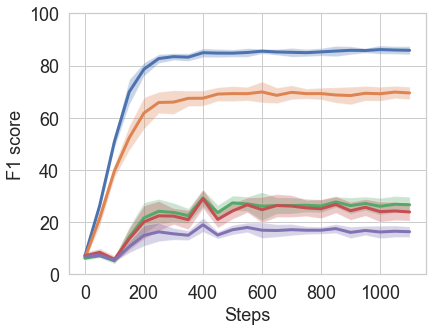

In [512]:
plt.figure(figsize=[6.4, 4.8])
for c in ['III', 'IOO', 'OIO', 'OOI', 'OOO']:
    ys = cat_to_ys_f1[c]
    stds = cat_to_stds_f1[c]
    if c == 'III':
        label = '$\mathcal{D}_{\mathrm{position}} \cap \mathcal{D}_{\mathrm{word}} \cap \mathcal{D}_{\mathrm{type}}$'
    elif c == 'IOO':
        label = '$\mathcal{D}_{\mathrm{position}} \cap \overline{\mathcal{D}_{\mathrm{word}}} \cap \overline{\mathcal{D}_{\mathrm{type}}}$'
    elif c == 'OIO':
        label = '$\overline{\mathcal{D}_{\mathrm{position}}} \cap \mathcal{D}_{\mathrm{word}} \cap \overline{\mathcal{D}_{\mathrm{type}}}$'
    elif c == 'OOI':
        label = '$\overline{\mathcal{D}_{\mathrm{position}}} \cap \overline{\mathcal{D}_{\mathrm{word}}} \cap \mathcal{D}_{\mathrm{type}}$'
    elif c == 'OOO':
        label = '$\overline{\mathcal{D}_{\mathrm{position}}} \cap \overline{\mathcal{D}_{\mathrm{word}}} \cap \overline{\mathcal{D}_{\mathrm{type}}}$'
    else:
        label = c
    plt.plot(xs, ys, label=label, linewidth=3)
    plus_std = [y+s for y, s in zip(ys, stds)]
    minuz_std = [y-s for y, s in zip(ys, stds)]
    plt.fill_between(xs, minuz_std, plus_std, alpha=.3)
fontsize = 18
plt.xlabel("Steps", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylabel("F1 score", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim(0, 100)

plt.show()

### BERT blend 1d

In [253]:
keys = [
    'answer-position-sentence',
    'question-context-similar-sent',
    'answer-candidates',
]
ar = {}
test_file_name = 'dev-v1.1'
for k in keys:
    ar[k] = get_analysis_result(k, test_file_name, 'ex-qa')

In [265]:
models_dict = {}

keys = ['aps', 'qcss', 'ac', 'qcss-not-none', 'ac-top-5k']
rates = ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']

for key in keys:
    models_dict[key] = [
        f'bert_squad_1d-blend-{key}-{r}_5k-ex'
        for r in rates
    ]

In [269]:
# for key in keys:
# for key in ['qcss', 'qcss-not-none']:

ac_threshold = None
seeds = [42, 43, 44, 45, 46]

for key in ['aps', 'qcss-not-none', 'ac']:
    xs = []
    yeasy_mean = []
    yeasy_std = []

    yhard_mean = []
    yhard_std = []

    yac_mean = defaultdict(list)
    yac_std = defaultdict(list)

    for model in models_dict[key]:
        print('Model:', model)
        r = float(model.split('_')[2].split('-')[-1])
        xs.append(r)
        yeasy_i = []
        yhard_i = []
        yac_i = defaultdict(list)

        for seed in seeds:
            m = model + f'_seed{seed}'
            predictions = load_json(output_dir / 'ex-qa' / m / f'predictions_{test_file_name}_.json')
            all_score, score_dict = evaluate(test_set['data'], predictions, return_dict=True)

            results = defaultdict(Statistics)
            

            for _id, score in score_dict.items():
                aps = ar['answer-position-sentence'][_id]
                qcss = ar['question-context-similar-sent'][_id]
                ac = ar['answer-candidates'][_id]
                if qcss is None:
                    continue
                if ac is None:
                    continue
                if '1d-blend-aps' in m:
                    category = str(int(aps == 0))
                elif '1d-blend-qcss' in m:
                    category = str(int(qcss == aps))
                elif '1d-blend-ac' in m:
                    category = str(int(ac == 1))
                else:
                    category = get_category(aps, qcss, ac, 3)
                if 'qcss' in key and qcss is None:
                    category = 'none'
                results[category].update_dict(score)

            if '1d' in m:
                cats = ['1', '0']
            else:
                raise ValueError("")
            for c in cats:
                stat = results[c]
                result = stat.mean()
                f1 = result['F1']
                em = result['EM']
                if c == '1':
                    yeasy_i.append(f1 * 100)
                elif c == '0':
                    yhard_i.append(f1 * 100)

            if 'ac' in key:
                results_ac = score_dict_to_stats_ac(score_dict, threshold=ac_threshold)
                # cats = [str(i) for i in range(1, ac_threshold+1)] + [f'{ac_threshold+1}~']
                for c in results_ac:
                    stat = results_ac[c]
                    yac_i[c].append(stat.mean()['F1'] * 100)

        yeasy_mean.append(np.mean(yeasy_i))
        yeasy_std.append(np.std(yeasy_i))
        yhard_mean.append(np.mean(yhard_i))
        yhard_std.append(np.std(yhard_i))
        for c in yac_i:
            yac_mean[c].append(np.mean(yac_i[c]))
            yac_std[c].append(np.std(yac_i[c]))
    
    exp_type = f'bert_squad_1d-blend-{key}'
    plot_data = {
        "xs": xs,
        "yeasy_mean": yeasy_mean,
        "yeasy_std": yeasy_std,
        "yhard_mean": yhard_mean,
        "yhard_std": yhard_std,
    }

    if 'ac' in key:        
        plot_data['yac_mean'] = yac_mean
        plot_data['yac_std'] = yac_std
        
    save_json(plot_data, Path('plot') / f'{exp_type}.json')
        

Model: bert_squad_1d-blend-aps-0.0_5k-ex
Model: bert_squad_1d-blend-aps-0.1_5k-ex
Model: bert_squad_1d-blend-aps-0.2_5k-ex
Model: bert_squad_1d-blend-aps-0.3_5k-ex
Model: bert_squad_1d-blend-aps-0.4_5k-ex
Model: bert_squad_1d-blend-aps-0.5_5k-ex
Model: bert_squad_1d-blend-aps-0.6_5k-ex
Model: bert_squad_1d-blend-aps-0.7_5k-ex
Model: bert_squad_1d-blend-aps-0.8_5k-ex
Model: bert_squad_1d-blend-aps-0.9_5k-ex
Model: bert_squad_1d-blend-aps-1.0_5k-ex
Model: bert_squad_1d-blend-qcss-not-none-0.0_5k-ex
Model: bert_squad_1d-blend-qcss-not-none-0.1_5k-ex
Model: bert_squad_1d-blend-qcss-not-none-0.2_5k-ex
Model: bert_squad_1d-blend-qcss-not-none-0.3_5k-ex
Model: bert_squad_1d-blend-qcss-not-none-0.4_5k-ex
Model: bert_squad_1d-blend-qcss-not-none-0.5_5k-ex
Model: bert_squad_1d-blend-qcss-not-none-0.6_5k-ex
Model: bert_squad_1d-blend-qcss-not-none-0.7_5k-ex
Model: bert_squad_1d-blend-qcss-not-none-0.8_5k-ex
Model: bert_squad_1d-blend-qcss-not-none-0.9_5k-ex
Model: bert_squad_1d-blend-qcss-not-non

E 83.75 83.92 83.88 83.83 83.15 83.73 83.01 82.01 80.96 79.35 51.29
H 19.46 68.6 74.36 77.23 78.99 80.61 81.19 81.57 81.96 82.36 82.13


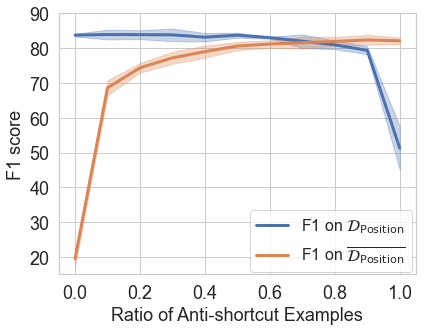

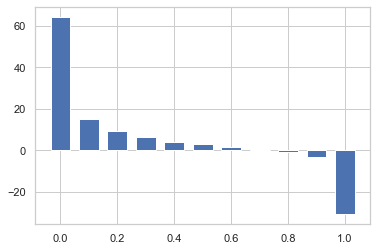

E 84.93 84.62 84.4 84.51 83.82 83.27 83.07 82.12 81.19 80.59 78.84
H 66.02 67.8 69.87 71.06 71.55 70.8 71.9 72.25 72.17 72.82 72.1


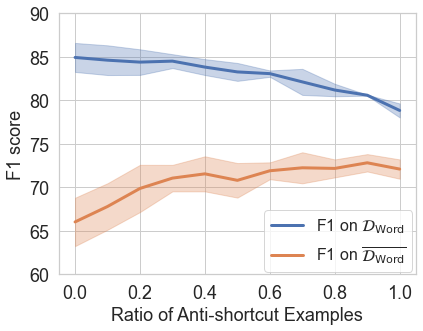

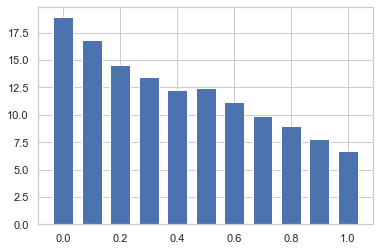

E 84.29 84.18 84.12 84.4 84.13 83.43 83.14 84.15 83.17 83.51 82.38
H 76.58 78.25 79.23 80.33 80.0 79.93 80.51 81.29 81.24 81.39 81.11


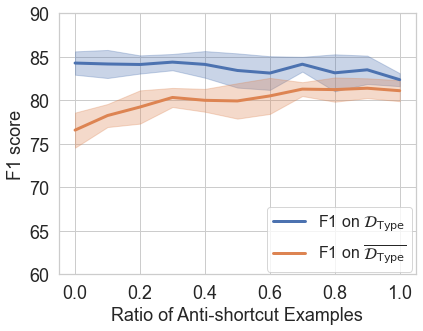

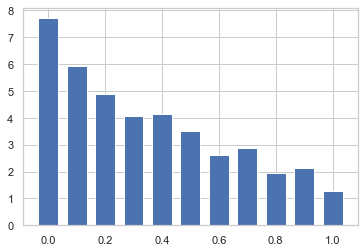

7 71.65 74.79 75.45 78.05 76.95 78.25 78.98 78.86 79.62 79.63 80.83


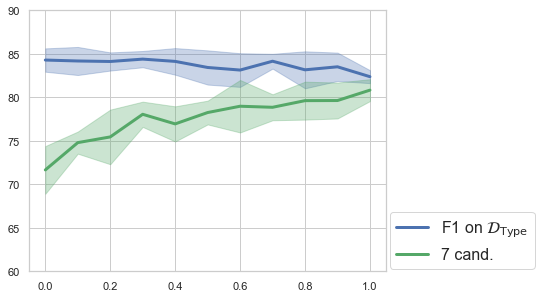

In [427]:
for key in ['aps', 'qcss-not-none', 'ac']:
    exp_type = f'bert_squad_1d-blend-{key}'
    plot_data = load_json(Path('plot') / f'{exp_type}.json')
    xs = plot_data["xs"]
    yeasy_mean = plot_data["yeasy_mean"]
    yeasy_std = plot_data["yeasy_std"]
    yhard_mean = plot_data["yhard_mean"]
    yhard_std = plot_data["yhard_std"]

    if 'ac' in key:        
        yac_mean = plot_data['yac_mean']
        yac_std = plot_data['yac_std']
    
    if key == 'aps':
        label1 = 'F1 on $\mathcal{D}_{\mathrm{Position}}$'
        label0 = 'F1 on $\overline{\mathcal{D}_{\mathrm{Position}}}$'
    elif 'qcss' in key:
        label1 = 'F1 on $\mathcal{D}_{\mathrm{Word}}$'
        label0 = 'F1 on $\overline{\mathcal{D}_{\mathrm{Word}}}$'
    elif 'ac' in key:
        label1 = 'F1 on $\mathcal{D}_{\mathrm{Type}}$'
        label0 = 'F1 on $\overline{\mathcal{D}_{\mathrm{Type}}}$'
        
    fontsize = 18

    plt.figure(figsize=[6.4, 4.8])
    plt.plot(xs, yeasy_mean, label=label1, linewidth=3, color="C0")
    print('E', ' '.join([str(round(y, 2)) for y in yeasy_mean]))
    plus_std = [y+s for y, s in zip(yeasy_mean, yeasy_std)]
    minus_std = [y-s for y, s in zip(yeasy_mean, yeasy_std)]
    plt.fill_between(xs, minus_std, plus_std, alpha=.3, color="C0")
    plt.plot(xs, yhard_mean, label=label0, linewidth=3, color="C1")
    plus_std = [y+s for y, s in zip(yhard_mean, yhard_std)]
    minus_std = [y-s for y, s in zip(yhard_mean, yhard_std)]
    plt.fill_between(xs, minus_std, plus_std, alpha=.3, color="C1")
    
    print('H', ' '.join([str(round(y, 2)) for y in yhard_mean]))
    if 'qcss' in key:
        plt.ylim(60, 90)
    elif 'ac' in key:
        plt.ylim(60, 90)
    else:
        plt.ylim(15, 90)
    # plt.ylim(15, 90)
    ydiff = [e - h for h, e in zip(yhard_mean, yeasy_mean)]
        # plt.plot(xs, ydiff, label='dif.', linewidth=3)
    plt.xlabel("Ratio of Anti-shortcut Examples", fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylabel("F1 score", fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend(bbox_to_anchor=(0.99, 0.01), loc='lower right', borderaxespad=0, fontsize=fontsize - 2) # , title = "Evaluated on", title_fontsize=fontsize)
    plt.show()

    plt.bar(xs, ydiff, align="center", width=0.07)
    plt.show()
    
    if 'ac' in key:
        plt.figure(figsize=[6.4, 4.8])
        color = 2
        # cats = [str(i) for i in range(1, ac_threshold+1)] + [f'{ac_threshold+1}~']
        plt.plot(xs, yeasy_mean, label=label1, linewidth=3, color="C0")
        plus_std = [y+s for y, s in zip(yeasy_mean, yeasy_std)]
        minus_std = [y-s for y, s in zip(yeasy_mean, yeasy_std)]
        plt.fill_between(xs, minus_std, plus_std, alpha=.3, color="C0")
        cats = sorted(map(int, yac_mean.keys()))
        for k in cats[6:7]:
            k = str(k)
            plt.plot(xs, yac_mean[k], label=f"{k} cand.", linewidth=3, color=f'C{color}')
            plus_std = [y+s for y, s in zip(yac_mean[k], yac_std[k])]
            minus_std = [y-s for y, s in zip(yac_mean[k], yac_std[k])]
            plt.fill_between(xs, minus_std, plus_std, alpha=.3, color=f'C{color}')
            print(k, ' '.join([str(round(y, 2)) for y in yac_mean[k]]))
            color += 1
        plt.ylim(60, 90)
        plt.legend(bbox_to_anchor=(1.01, 0.01), loc='lower left', borderaxespad=0, fontsize=fontsize - 2) # , title = "Evaluated on", title_fontsize=fontsize)
        plt.show()

In [156]:
results_ac

defaultdict(my_utils.data.stat.Statistics,
            {'5~': <my_utils.data.stat.Statistics at 0x7fbf62800668>,
             2: <my_utils.data.stat.Statistics at 0x7fbf62800080>,
             1: <my_utils.data.stat.Statistics at 0x7fbf62800128>,
             4: <my_utils.data.stat.Statistics at 0x7fbf62800400>,
             3: <my_utils.data.stat.Statistics at 0x7fbf62800358>})

### Roberta

In [513]:
exp_type = 'roberta_squad'

In [514]:
plot_data = load_json(Path('plot') / f'{exp_type}.json')
xs = plot_data["xs"]
cat_to_ys_f1 = plot_data["cat_to_ys"]
cat_to_stds_f1 = plot_data["cat_to_stds"]

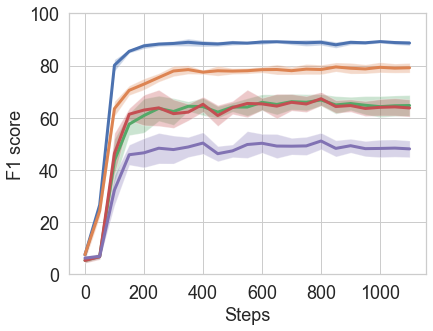

In [515]:
plt.figure(figsize=[6.4, 4.8])
for c in ['III', 'IOO', 'OIO', 'OOI', 'OOO']:
    ys = cat_to_ys_f1[c]
    stds = cat_to_stds_f1[c]
    if c == 'III':
        label = '$\mathcal{D}_{\mathrm{Position}} \cap \mathcal{D}_{\mathrm{Word}} \cap \mathcal{D}_{\mathrm{Type}}$'
    elif c == 'IOO':
        label = '$\mathcal{D}_{\mathrm{Position}} \cap \overline{\mathcal{D}_{\mathrm{Word}}} \cap \overline{\mathcal{D}_{\mathrm{Type}}}$'
    elif c == 'OIO':
        label = '$\overline{\mathcal{D}_{\mathrm{Position}}} \cap \mathcal{D}_{\mathrm{Word}} \cap \overline{\mathcal{D}_{\mathrm{Type}}}$'
    elif c == 'OOI':
        label = '$\overline{\mathcal{D}_{\mathrm{Position}}} \cap \overline{\mathcal{D}_{\mathrm{Word}}} \cap \mathcal{D}_{\mathrm{Type}}$'
    elif c == 'OOO':
        label = '$\overline{\mathcal{D}_{\mathrm{Position}}} \cap \overline{\mathcal{D}_{\mathrm{Word}}} \cap \overline{\mathcal{D}_{\mathrm{Type}}}$'
    else:
        label = c
    plt.plot(xs, ys, label=label, linewidth=3)
    plus_std = [y+s for y, s in zip(ys, stds)]
    minuz_std = [y-s for y, s in zip(ys, stds)]
    plt.fill_between(xs, minuz_std, plus_std, alpha=.3)
fontsize = 18
plt.xlabel("Steps", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylabel("F1 score", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim(0, 100)
plt.show()

## Legend

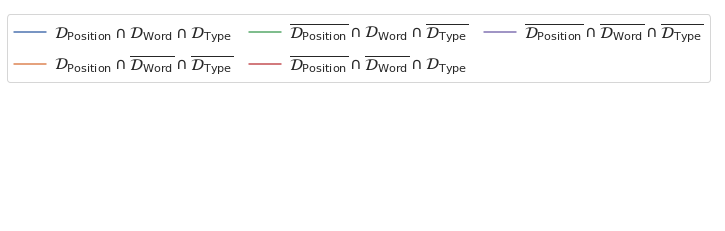

In [548]:
fig, ax = plt.subplots()

for spine in ax.spines.values():
    spine.set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

cats = ['III', 'IOO', 'OIO', 'OOI', 'OOO']
for c in cats:
    if c == 'III':
        label = '$\mathcal{D}_{\mathrm{Position}} \cap \mathcal{D}_{\mathrm{Word}} \cap \mathcal{D}_{\mathrm{Type}}$'
    elif c == 'IOO':
        label = '$\mathcal{D}_{\mathrm{Position}} \cap \overline{\mathcal{D}_{\mathrm{Word}}} \cap \overline{\mathcal{D}_{\mathrm{Type}}}$'
    elif c == 'OIO':
        label = '$\overline{\mathcal{D}_{\mathrm{Position}}} \cap \mathcal{D}_{\mathrm{Word}} \cap \overline{\mathcal{D}_{\mathrm{Type}}}$'
    elif c == 'OOI':
        label = '$\overline{\mathcal{D}_{\mathrm{Position}}} \cap \overline{\mathcal{D}_{\mathrm{Word}}} \cap \mathcal{D}_{\mathrm{Type}}$'
    elif c == 'OOO':
        label = '$\overline{\mathcal{D}_{\mathrm{Position}}} \cap \overline{\mathcal{D}_{\mathrm{Word}}} \cap \overline{\mathcal{D}_{\mathrm{Type}}}$'

    ax.plot([], [], marker="", label=label) # , linestyle="none")

legend = ax.legend(frameon=True, handletextpad=0.5, ncol=3, columnspacing=1, fontsize=16)

legend_fig = legend.figure
legend_fig.canvas.draw()
bbox = legend.get_window_extent().transformed(legend_fig.dpi_scale_trans.inverted())

## NQ

### BERT

In [516]:
exp_type = 'bert_nq'

In [517]:
plot_data = load_json(Path('plot') / f'{exp_type}.json')
xs = plot_data["xs"]
cat_to_ys_f1 = plot_data["cat_to_ys"]
cat_to_stds_f1 = plot_data["cat_to_stds"]

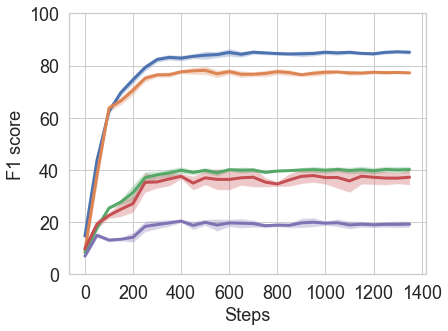

In [518]:
plt.figure(figsize=[6.4, 4.8])
for c in ['III', 'IOO', 'OIO', 'OOI', 'OOO']:
    ys = cat_to_ys_f1[c]
    stds = cat_to_stds_f1[c]
    if c == 'III':
        label = '$\mathcal{D}_{\mathrm{position}} \cap \mathcal{D}_{\mathrm{word}} \cap \mathcal{D}_{\mathrm{type}}$'
    elif c == 'IOO':
        label = '$\mathcal{D}_{\mathrm{position}} \cap \overline{\mathcal{D}_{\mathrm{word}}} \cap \overline{\mathcal{D}_{\mathrm{type}}}$'
    elif c == 'OIO':
        label = '$\overline{\mathcal{D}_{\mathrm{position}}} \cap \mathcal{D}_{\mathrm{word}} \cap \overline{\mathcal{D}_{\mathrm{type}}}$'
    elif c == 'OOI':
        label = '$\overline{\mathcal{D}_{\mathrm{position}}} \cap \overline{\mathcal{D}_{\mathrm{word}}} \cap \mathcal{D}_{\mathrm{type}}$'
    elif c == 'OOO':
        label = '$\overline{\mathcal{D}_{\mathrm{position}}} \cap \overline{\mathcal{D}_{\mathrm{word}}} \cap \overline{\mathcal{D}_{\mathrm{type}}}$'
    else:
        label = c
    plt.plot(xs, ys, label=label, linewidth=3)
    plus_std = [y+s for y, s in zip(ys, stds)]
    minuz_std = [y-s for y, s in zip(ys, stds)]
    plt.fill_between(xs, minuz_std, plus_std, alpha=.3)
fontsize = 18
plt.xlabel("Steps", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylabel("F1 score", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim(0, 100)

plt.show()

bert_nq_biased-aps-0-qcss-0-ac-1_10ep_4k-ex_seed46
NaturalQuestionsShort-dev-from-MRQA


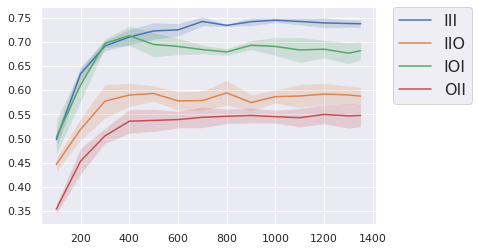

In [73]:
print(model)
print(test_file_name)
for c in ['III', 'IIO', 'IOI', 'OII']:
    ys = cat_to_ys_em[c]
    stds = cat_to_stds_em[c]
    plt.plot(xs, ys, label=c)
    plus_std = [y+s for y, s in zip(ys, stds)]
    minuz_std = [y-s for y, s in zip(ys, stds)]
    plt.fill_between(xs, minuz_std, plus_std, alpha=.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=16)
plt.show()

### Roberta

In [519]:
exp_type = 'roberta_nq'

In [520]:
plot_data = load_json(Path('plot') / f'{exp_type}.json')
xs = plot_data["xs"]
cat_to_ys_f1 = plot_data["cat_to_ys"]
cat_to_stds_f1 = plot_data["cat_to_stds"]

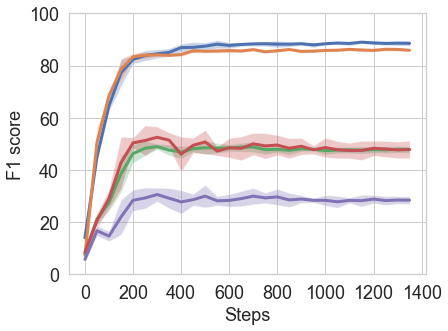

In [521]:
plt.figure(figsize=[6.4, 4.8])
for c in ['III', 'IOO', 'OIO', 'OOI', 'OOO']:
    ys = cat_to_ys_f1[c]
    stds = cat_to_stds_f1[c]
    if c == 'III':
        label = '$\mathcal{D}_{\mathrm{position}} \cap \mathcal{D}_{\mathrm{word}} \cap \mathcal{D}_{\mathrm{type}}$'
    elif c == 'IOO':
        label = '$\mathcal{D}_{\mathrm{position}} \cap \overline{\mathcal{D}_{\mathrm{word}}} \cap \overline{\mathcal{D}_{\mathrm{type}}}$'
    elif c == 'OIO':
        label = '$\overline{\mathcal{D}_{\mathrm{position}}} \cap \mathcal{D}_{\mathrm{word}} \cap \overline{\mathcal{D}_{\mathrm{type}}}$'
    elif c == 'OOI':
        label = '$\overline{\mathcal{D}_{\mathrm{position}}} \cap \overline{\mathcal{D}_{\mathrm{word}}} \cap \mathcal{D}_{\mathrm{type}}$'
    elif c == 'OOO':
        label = '$\overline{\mathcal{D}_{\mathrm{position}}} \cap \overline{\mathcal{D}_{\mathrm{word}}} \cap \overline{\mathcal{D}_{\mathrm{type}}}$'
    else:
        label = c
    plt.plot(xs, ys, label=label, linewidth=3)
    plus_std = [y+s for y, s in zip(ys, stds)]
    minuz_std = [y-s for y, s in zip(ys, stds)]
    plt.fill_between(xs, minuz_std, plus_std, alpha=.3)
fontsize = 18
plt.xlabel("Steps", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylabel("F1 score", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim(0, 100)

plt.show()

roberta_nq_3d-biased-aps-qcss-ac_seed46
NaturalQuestionsShort-dev-from-MRQA


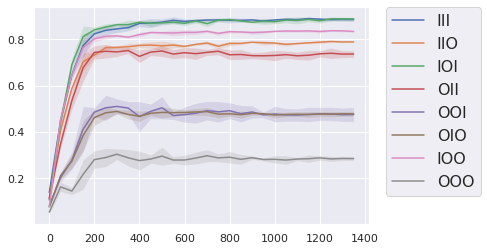

In [295]:
print(model)
print(test_file_name)
for c in ['III', 'IIO', 'IOI', 'OII', 'OOI', 'OIO', 'IOO', 'OOO']:
    ys = cat_to_ys_f1[c]
    stds = cat_to_stds_f1[c]
    plt.plot(xs, ys, label=c)
    plus_std = [y+s for y, s in zip(ys, stds)]
    minuz_std = [y-s for y, s in zip(ys, stds)]
    plt.fill_between(xs, minuz_std, plus_std, alpha=.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=16)
plt.show()

# MCQA

## Count examples

In [401]:
LO = 'correct-has-max-lexical-overlap'
LON = 'correct-has-max-lexical-overlap-with-none'

TOP1 = 'only-correct-has-top1-word'
TOP1N = 'only-correct-has-top1-word-with-none'

In [390]:


test_file_name = "race-test"
# test_file_name = "reclor-train"
# file_name = "race-train"
keys = [
    LO,
    # 'only-correct-has-top50-words',
    TOP1,
    TOP1N,
]
ar = {}
for k in keys:
    ar[k] = get_analysis_result(k, test_file_name, 'mc-qa')

In [391]:
ids = ar[k].keys()
cat2d = []

for _id in ids:
    lo = ar[LO][_id]
    top1 = ar[TOP1N][_id]
    cat2d.append(f"{top1}"f"{lo}")

In [392]:
cats = Counter(cat2d)

In [238]:
cats['00'] + cats['01'], cats['10'] + cats['11']

(83335, 4530)

In [239]:
cats['00'] + cats['10'], cats['01'] + cats['11']

(69174, 18691)

## Evaluation

In [244]:
from utils_multiple_choice import  RaceProcessor, ReclorProcessor
race_processor = RaceProcessor()
reclor_processor = ReclorProcessor()
race_dir = os.environ['RACE_DIR']
reclor_dir = os.environ['ReClor_DIR']
race_test_examples = race_processor.get_test_examples(race_dir)
reclor_test_examples = reclor_processor.get_test_examples(reclor_dir)

read files: 100%|██████████| 362/362 [00:00<00:00, 1322.27it/s]


In [71]:
len(race_test_examples)

4934

In [72]:
len(reclor_test_examples)

1000

In [175]:
models = [
    'roberta_race',
    'roberta_race_biased-maxlo-1-top50-1_seed42',
    'bert_race_biased-maxlo-1-top50-1_seed42',
    'bert_race_biased-maxlo-0-top50-1_seed42',
    'bert_race_biased-maxlo-1-top50-0_seed42',
    'bert_race_biased-maxlo-0-top50-1_5k-ex_seed42',
    'bert_race_biased-maxlo-1-top50-0_5k-ex_seed42',
]

In [270]:
models = [
    'bert_race_biased-maxlo-1-top1-1_seed42',
    'bert_race_biased-maxlo-0-top1-1_3k-ex_seed42',
    'bert_race_biased-maxlo-1-top1-0_3k-ex_seed42',
]

In [286]:
models = [
    'bert_reclor_biased-maxlo-1-top1-1_seed42',
]

In [321]:
models = [
    "bert_reclor_biased-maxlo-1-top1-1_seed42",
    "bert_reclor_biased-maxlo-1-top1-1_seed42_with-old-hyp",
    "bert_reclor_biased-maxlo-0-top1-1_300-ex_seed42",
    "bert_reclor_biased-maxlo-1-top1-0_300-ex_seed42",
]

In [240]:
models = [
    "bert_race_1d-blend-maxlo-0.1_4k-ex_seed42",
    "bert_race_1d-blend-top1-0.1_4k-ex_seed42"
]

In [285]:
test_file_name = "race-test"
# test_file_name = "reclor-test"
keys = [
    'correct-has-max-lexical-overlap',
    # 'only-correct-has-top50-words',
    'only-correct-has-top1-word',
]
ar = {}
for k in keys:
    ar[k] = get_analysis_result(k, test_file_name, 'mc-qa')

In [286]:
id2label = {e.example_id + e.question + ''.join(e.endings): e.label for e in race_test_examples}

In [318]:
id2label = {e.example_id: e.label for e in reclor_test_examples}

In [246]:
len(id2label)

4934

In [249]:
for m in models:
    print(m)
    results = defaultdict(Statistics)
    predictions = load_json(output_dir / 'mc-qa' / m / f'predictions_predict_.json')
    for _id in tqdm(predictions):
        pred = int(predictions[_id])
        label = int(id2label[_id])
        cat = ''
        for k in keys:
            cat += str(ar[k][_id])
        results[cat].update_dict({'acc': int(pred == label)})
    for c in ['11', '10', '01', '00']:
        stat = results[c]
        result = stat.mean()
        acc = result['acc']
        print(c, '\t', round(acc * 100, 2), '\t', '') # , '\t', stat.global_update)
    print()

bert_race_1d-blend-maxlo-0.1_4k-ex_seed42


100%|██████████| 4934/4934 [00:00<00:00, 225143.02it/s]


11 	 79.69 	 
10 	 73.64 	 
01 	 30.93 	 
00 	 28.52 	 

bert_race_1d-blend-top1-0.1_4k-ex_seed42


100%|██████████| 4934/4934 [00:00<00:00, 219838.28it/s]

11 	 100.0 	 
10 	 14.33 	 
01 	 100.0 	 
00 	 20.78 	 



## Training Dynamics

In [197]:
# exp_type = 'bert_race'
# exp_type = 'bert_reclor'
# exp_type = 'roberta_race'
exp_type = 'roberta_reclor'

In [198]:
cats = ['11', '10', '01', '00']
seeds = [42, 43, 44, 45, 46]
# seeds = [42]
models = []
for seed in seeds:
    if exp_type == 'bert_race':
        models.append(f'bert_race_biased-maxlo-1-top1-1_seed{seed}')
    elif exp_type == 'roberta_race':
        models.append(f'roberta_race_biased-maxlo-1-top1-1_seed{seed}')
    elif exp_type == 'bert_reclor':
        models.append(f'bert_reclor_biased-maxlo-1-top1-1_seed{seed}')
    elif exp_type == 'roberta_reclor':
        models.append(f'roberta_reclor_biased-maxlo-1-top1-1_seed{seed}')
    else:
        raise ValueError
if 'race' in exp_type:
    test_file_name = 'race-test'
    steps = [int(i * 25) for i in range(500 // 25 + 1)]
    id2label = {e.example_id + e.question + ''.join(e.endings): e.label for e in race_test_examples}
elif 'reclor' in exp_type:
    test_file_name = 'reclor-test'
    steps = [int(i * 10) for i in range(200 // 10 + 1)]
    id2label = {e.example_id: e.label for e in reclor_test_examples}
else:
    raise ValueError

keys = [
    'only-correct-has-top1-word',
    'correct-has-max-lexical-overlap',
    # 'only-correct-has-top50-words',
]
ar = {}
for k in keys:
    ar[k] = get_analysis_result(k, test_file_name, 'mc-qa')

xs = []
cat_to_ys = defaultdict(list)
cat_to_stds = defaultdict(list)

for step in tqdm(steps):
    cat_to_acc = defaultdict(list)
    for model in models:
        predictions = load_json(output_dir / 'mc-qa' / model / f'predictions_predict_{step}.json')
        results = defaultdict(Statistics)
        for _id in predictions:
            pred = int(predictions[_id])
            label = int(id2label[_id])
            cat = ''
            for k in keys:
                cat += str(ar[k][_id])
            results[cat].update_dict({'acc': int(pred == label)})
        for c in cats:
            stat = results[c]
            mean = stat.mean()
            cat_to_acc[c].append(mean['acc'] * 100)

    for c in cats:
        cat_to_ys[c].append(np.mean(cat_to_acc[c]))
        cat_to_stds[c].append(np.std(cat_to_acc[c]))
    if step != '':
        step = int(step)
    else:
        if 'squad' in exp_type:
            step = 1150
        elif 'nq' in exp_type:
            step = 1350
        elif 'race' in exp_type:
            step = 530
    
    xs.append(step)

100%|██████████| 21/21 [00:01<00:00, 19.89it/s]


In [199]:
exp_type

'roberta_reclor'

In [200]:
plot_data = {
    "xs": xs,
    "cat_to_ys": cat_to_ys,
    "cat_to_stds": cat_to_stds
}
save_json(plot_data, Path('plot') / f'{exp_type}.json')

## Legend

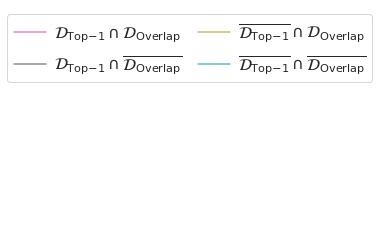

In [547]:
fig, ax = plt.subplots()

for spine in ax.spines.values():
    spine.set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

for c, color in zip(['11', '10', '01', '00'], ['C6', 'C7', 'C8', 'C9']):
    if c == '11':
        label = '$\mathcal{D}_{\mathrm{Top{-}1}} \cap \mathcal{D}_{\mathrm{Overlap}}$'
    elif c == '10':
        label = '$\mathcal{D}_{\mathrm{Top{-}1}} \cap \overline{\mathcal{D}_{\mathrm{Overlap}}}$'
    elif c == '01':
        label = '$\overline{\mathcal{D}_{\mathrm{Top{-}1}}} \cap \mathcal{D}_{\mathrm{Overlap}}$'
    elif c == '00':
        label = '$\overline{\mathcal{D}_{\mathrm{Top{-}1}}} \cap \overline{\mathcal{D}_{\mathrm{Overlap}}}$'
    ax.plot([], [], marker="", label=label, color=color) # , linestyle="none")

legend = ax.legend(frameon=True, handletextpad=0.5, ncol=2, columnspacing=1, fontsize=16)

legend_fig = legend.figure
legend_fig.canvas.draw()
bbox = legend.get_window_extent().transformed(legend_fig.dpi_scale_trans.inverted())

## RACE

### BERT

In [549]:
exp_type = 'bert_race'

In [550]:
plot_data = load_json(Path('plot') / f'{exp_type}.json')
xs = plot_data["xs"]
cat_to_ys = plot_data["cat_to_ys"]
cat_to_stds = plot_data["cat_to_stds"]

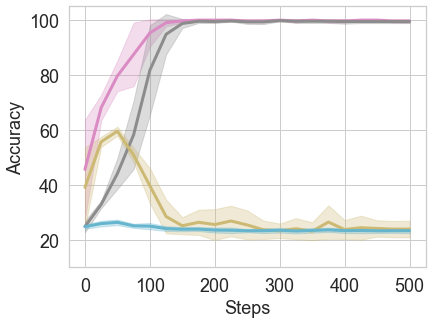

In [551]:
plt.figure(figsize=[6.4, 4.8])
for c, color in zip(['11', '10', '01', '00'], ['C6', 'C7', 'C8', 'C9']):
    ys = cat_to_ys[c]
    stds = cat_to_stds[c]
    if c == '11':
        label = '$\mathcal{D}_{\mathrm{Top{-}1}} \cap \mathcal{D}_{\mathrm{Overlap}}$'
    elif c == '10':
        label = '$\mathcal{D}_{\mathrm{Top{-}1}} \cap \overline{\mathcal{D}_{\mathrm{Overlap}}}$'
    elif c == '01':
        label = '$\overline{\mathcal{D}_{\mathrm{Top{-}1}}} \cap \mathcal{D}_{\mathrm{Overlap}}$'
    elif c == '00':
        label = '$\overline{\mathcal{D}_{\mathrm{Top{-}1}}} \cap \overline{\mathcal{D}_{\mathrm{Overlap}}}$'
    else:
        label = c
    plt.plot(xs, ys, label=label, color=color, linewidth=3)
    plus_std = [y+s for y, s in zip(ys, stds)]
    minuz_std = [y-s for y, s in zip(ys, stds)]
    plt.fill_between(xs, minuz_std, plus_std, alpha=.3, color=color)

fontsize = 18
plt.xlabel("Steps", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylabel("Accuracy", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim(10, 105)
# plt.legend(bbox_to_anchor=(0.97, 0.6), loc='center right', borderaxespad=0, fontsize=fontsize) # , title = "Evaluated on", title_fontsize = 13)

plt.show()

### BERT blend

In [411]:
key_names = {
    LO: 'maxlo',
    LON: 'maxlo-with-none',
    TOP1: 'top1',
    TOP1N: 'top1-with-none',
    # TOP2: 'top1n',
}

In [428]:
models_dict = {}

keys = [LON, TOP1N]
rates = ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']

for key in keys:
    key_name = key_names[key]
    models_dict[key] = [
        f'bert_race_1d-blend-{key_name}-{r}_4k-ex'
        for r in rates
    ]

In [429]:
seeds = [42, 43, 44, 45, 46]

for key in [LON, TOP1N]:
    xs = []
    yeasy_mean = []
    yeasy_std = []

    yhard_mean = []
    yhard_std = []

    for model in models_dict[key]:
        print('Model:', model)
        r = float(model.split('_')[2].split('-')[-1])
        xs.append(r)
        yeasy_i = []
        yhard_i = []

        for seed in seeds:
            results = defaultdict(Statistics)
            
            m = model + f'_seed{seed}'
            predictions = load_json(output_dir / 'mc-qa' / m / f'predictions_predict_.json')
            for _id in predictions:
                lo = ar[LO][_id]
                top1 = ar[TOP1][_id]
                top1n = ar[TOP1N][_id]
                if top1n is None:
                    continue
                if '1d-blend-maxlo' in m:
                    category = str(lo)
                elif '1d-blend-top1' in m:
                    category = str(top1)
                else:
                    raise ValueError(m)
                pred = int(predictions[_id])
                label = int(id2label[_id])
                results[category].update_dict({'acc': int(pred == label)})

            cats = ['1', '0']
            for c in cats:
                stat = results[c]
                result = stat.mean()
                acc = result['acc']
                if c == '1':
                    yeasy_i.append(acc * 100)
                elif c == '0':
                    yhard_i.append(acc * 100)

        yeasy_mean.append(np.mean(yeasy_i))
        yeasy_std.append(np.std(yeasy_i))
        yhard_mean.append(np.mean(yhard_i))
        yhard_std.append(np.std(yhard_i))
        for c in yac_i:
            yac_mean[c].append(np.mean(yac_i[c]))
            yac_std[c].append(np.std(yac_i[c]))
    
    if key == LO:
        exp_type = 'bert_race_1d-blend-maxlo'
    elif key == LON:
        exp_type = 'bert_race_1d-blend-maxlo-with-none'
    elif key == TOP1:
        exp_type = 'bert_race_1d-blend-top1'
    elif key == TOP1N:
        exp_type = 'bert_race_1d-blend-top1-with-none'
    else:
        raise ValueError(key)
    plot_data = {
        "xs": xs,
        "yeasy_mean": yeasy_mean,
        "yeasy_std": yeasy_std,
        "yhard_mean": yhard_mean,
        "yhard_std": yhard_std,
    }

    save_json(plot_data, Path('plot') / f'{exp_type}.json')

Model: bert_race_1d-blend-maxlo-with-none-0.0_4k-ex
Model: bert_race_1d-blend-maxlo-with-none-0.1_4k-ex
Model: bert_race_1d-blend-maxlo-with-none-0.2_4k-ex
Model: bert_race_1d-blend-maxlo-with-none-0.3_4k-ex
Model: bert_race_1d-blend-maxlo-with-none-0.4_4k-ex
Model: bert_race_1d-blend-maxlo-with-none-0.5_4k-ex
Model: bert_race_1d-blend-maxlo-with-none-0.6_4k-ex
Model: bert_race_1d-blend-maxlo-with-none-0.7_4k-ex
Model: bert_race_1d-blend-maxlo-with-none-0.8_4k-ex
Model: bert_race_1d-blend-maxlo-with-none-0.9_4k-ex
Model: bert_race_1d-blend-maxlo-with-none-1.0_4k-ex
Model: bert_race_1d-blend-top1-with-none-0.0_4k-ex
Model: bert_race_1d-blend-top1-with-none-0.1_4k-ex
Model: bert_race_1d-blend-top1-with-none-0.2_4k-ex
Model: bert_race_1d-blend-top1-with-none-0.3_4k-ex
Model: bert_race_1d-blend-top1-with-none-0.4_4k-ex
Model: bert_race_1d-blend-top1-with-none-0.5_4k-ex
Model: bert_race_1d-blend-top1-with-none-0.6_4k-ex
Model: bert_race_1d-blend-top1-with-none-0.7_4k-ex
Model: bert_race_1d-

E 68.02 67.06 67.06 65.35 62.03 61.5 59.89 54.97 42.89 34.33 20.43
H 22.53 23.71 24.84 25.77 26.15 28.11 30.39 29.45 32.32 33.82 31.67


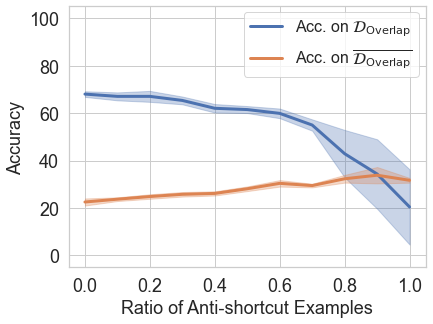

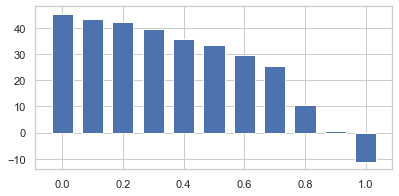

E 100.0 99.77 99.53 97.67 86.82 75.12 59.07 45.81 35.27 25.97 8.14
H 0.0 0.04 0.32 2.7 9.82 19.68 27.68 31.44 35.51 37.82 39.09


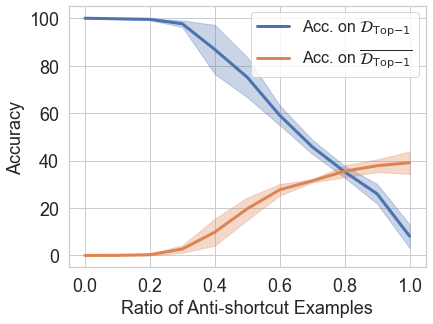

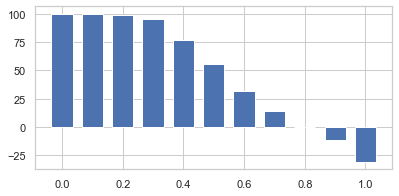

In [431]:
for key in [LON, TOP1N]:
    if key == LO:
        exp_type = 'bert_race_1d-blend-maxlo'
    elif key == LON:
        exp_type = 'bert_race_1d-blend-maxlo-with-none'
    elif key == TOP1:
        exp_type = 'bert_race_1d-blend-top1'
    elif key == TOP1N:
        exp_type = 'bert_race_1d-blend-top1-with-none'
    else:
        raise ValueError(key)
    plot_data = load_json(Path('plot') / f'{exp_type}.json')
    xs = plot_data["xs"]
    yeasy_mean = plot_data["yeasy_mean"]
    yeasy_std = plot_data["yeasy_std"]
    yhard_mean = plot_data["yhard_mean"]
    yhard_std = plot_data["yhard_std"]

    if 'ac' in key:        
        yac_mean = plot_data['yac_mean']
        yac_std = plot_data['yac_std']
    
    plt.figure(figsize=[6.4, 4.8])
    if key == LO or key == LON:
        label1 = 'Acc. on $\mathcal{D}_{\mathrm{Overlap}}$'
        label0 = 'Acc. on $\overline{\mathcal{D}_{\mathrm{Overlap}}}$'
        plt.ylim(-5, 105)
    elif key == TOP1 or key == TOP1N:
        label1 = 'Acc. on $\mathcal{D}_{\mathrm{Top{-}1}}$'
        label0 = 'Acc. on $\overline{\mathcal{D}_{\mathrm{Top{-}1}}}$'
        plt.ylim(-5, 105)
        
    fontsize = 18

    plt.plot(xs, yeasy_mean, label=label1, linewidth=3, color="C0")
    print('E', ' '.join([str(round(y, 2)) for y in yeasy_mean]))
    plus_std = [y+s for y, s in zip(yeasy_mean, yeasy_std)]
    minus_std = [y-s for y, s in zip(yeasy_mean, yeasy_std)]
    plt.fill_between(xs, minus_std, plus_std, alpha=.3, color="C0")
    plt.plot(xs, yhard_mean, label=label0, linewidth=3, color="C1")
    plus_std = [y+s for y, s in zip(yhard_mean, yhard_std)]
    minus_std = [y-s for y, s in zip(yhard_mean, yhard_std)]
    plt.fill_between(xs, minus_std, plus_std, alpha=.3, color="C1")

    print('H', ' '.join([str(round(y, 2)) for y in yhard_mean]))
    ydiff = [e - h for h, e in zip(yhard_mean, yeasy_mean)]
        # plt.plot(xs, ydiff, label='dif.', linewidth=3)

    plt.xlabel("Ratio of Anti-shortcut Examples", fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylabel("Accuracy", fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend(bbox_to_anchor=(0.98, 0.98), loc='upper right', borderaxespad=0, fontsize=fontsize - 2) # , title = "Evaluated on", title_fontsize=fontsize)
    plt.show()

    plt.figure(figsize=[6.4, 3])
    plt.bar(xs, ydiff, align="center", width=0.07)
    plt.show()

### RoBERTa

In [357]:
exp_type = 'roberta_race'

In [358]:
plot_data = load_json(Path('plot') / f'{exp_type}.json')
xs = plot_data["xs"]
cat_to_ys = plot_data["cat_to_ys"]
cat_to_stds = plot_data["cat_to_stds"]

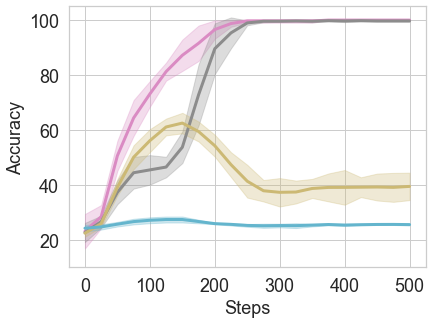

In [359]:
plt.figure(figsize=[6.4, 4.8])
for c, color in zip(['11', '10', '01', '00'], ['C6', 'C7', 'C8', 'C9']):
    ys = cat_to_ys[c]
    stds = cat_to_stds[c]
    if c == '11':
        label = '$\mathcal{D}_{\mathrm{top1}} \cap \mathcal{D}_{\mathrm{overlap}}$'
    elif c == '10':
        label = '$\mathcal{D}_{\mathrm{top1}} \cap \overline{\mathcal{D}_{\mathrm{overlap}}}$'
    elif c == '01':
        label = '$\overline{\mathcal{D}_{\mathrm{top1}}} \cap \mathcal{D}_{\mathrm{overlap}}$'
    elif c == '00':
        label = '$\overline{\mathcal{D}_{\mathrm{top1}}} \cap \overline{\mathcal{D}_{\mathrm{overlap}}}$'
    else:
        label = c
    plt.plot(xs, ys, label=label, color=color, linewidth=3)
    plus_std = [y+s for y, s in zip(ys, stds)]
    minuz_std = [y-s for y, s in zip(ys, stds)]
    plt.fill_between(xs, minuz_std, plus_std, alpha=.3, color=color)

fontsize = 18
plt.xlabel("Steps", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylabel("Accuracy", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim(10, 105)
# plt.legend(bbox_to_anchor=(0.99, 0.33), loc='lower right', borderaxespad=0, fontsize=fontsize) # , title = "Evaluated on", title_fontsize = 13)

plt.show()

## ReClor

### BERT

In [360]:
exp_type = 'bert_reclor'

In [361]:
plot_data = load_json(Path('plot') / f'{exp_type}.json')
xs = plot_data["xs"]
cat_to_ys = plot_data["cat_to_ys"]
cat_to_stds = plot_data["cat_to_stds"]

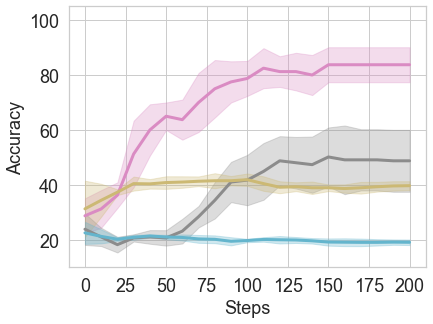

In [362]:
plt.figure(figsize=[6.4, 4.8])
for c, color in zip(['11', '10', '01', '00'], ['C6', 'C7', 'C8', 'C9']):
    ys = cat_to_ys[c]
    stds = cat_to_stds[c]
    if c == '11':
        label = '$\mathcal{D}_{\mathrm{top1}} \cap \mathcal{D}_{\mathrm{overlap}}$'
    elif c == '10':
        label = '$\mathcal{D}_{\mathrm{top1}} \cap \overline{\mathcal{D}_{\mathrm{overlap}}}$'
    elif c == '01':
        label = '$\overline{\mathcal{D}_{\mathrm{top1}}} \cap \mathcal{D}_{\mathrm{overlap}}$'
    elif c == '00':
        label = '$\overline{\mathcal{D}_{\mathrm{top1}}} \cap \overline{\mathcal{D}_{\mathrm{overlap}}}$'
    else:
        label = c
    plt.plot(xs, ys, label=label, color=color, linewidth=3)
    plus_std = [y+s for y, s in zip(ys, stds)]
    minuz_std = [y-s for y, s in zip(ys, stds)]
    plt.fill_between(xs, minuz_std, plus_std, alpha=.3, color=color)

fontsize = 18
plt.xlabel("Steps", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylabel("Accuracy", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim(10, 105)
# plt.legend(bbox_to_anchor=(0.99, 0.33), loc='lower right', borderaxespad=0, fontsize=fontsize) # , title = "Evaluated on", title_fontsize = 13)

plt.show()

### RoBERTa

In [363]:
exp_type = 'roberta_reclor'

In [364]:
plot_data = load_json(Path('plot') / f'{exp_type}.json')
xs = plot_data["xs"]
cat_to_ys = plot_data["cat_to_ys"]
cat_to_stds = plot_data["cat_to_stds"]

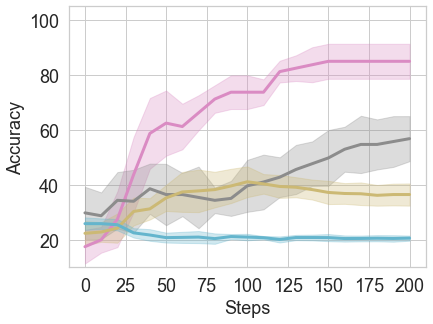

In [365]:
plt.figure(figsize=[6.4, 4.8])
for c, color in zip(['11', '10', '01', '00'], ['C6', 'C7', 'C8', 'C9']):
    ys = cat_to_ys[c]
    stds = cat_to_stds[c]
    if c == '11':
        label = '$\mathcal{D}_{\mathrm{top1}} \cap \mathcal{D}_{\mathrm{overlap}}$'
    elif c == '10':
        label = '$\mathcal{D}_{\mathrm{top1}} \cap \overline{\mathcal{D}_{\mathrm{overlap}}}$'
    elif c == '01':
        label = '$\overline{\mathcal{D}_{\mathrm{top1}}} \cap \mathcal{D}_{\mathrm{overlap}}$'
    elif c == '00':
        label = '$\overline{\mathcal{D}_{\mathrm{top1}}} \cap \overline{\mathcal{D}_{\mathrm{overlap}}}$'
    else:
        label = c
    plt.plot(xs, ys, label=label, color=color, linewidth=3)
    plus_std = [y+s for y, s in zip(ys, stds)]
    minuz_std = [y-s for y, s in zip(ys, stds)]
    plt.fill_between(xs, minuz_std, plus_std, alpha=.3, color=color)

fontsize = 18
plt.xlabel("Steps", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylabel("Accuracy", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim(10, 105)
# plt.legend(bbox_to_anchor=(0.99, 0.33), loc='lower right', borderaxespad=0, fontsize=fontsize) # , title = "Evaluated on", title_fontsize = 13)

plt.show()